# Malicious URL Detection using Machine Learning

#### Importing the neccessary packages

In [133]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from time import process_time
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import pickle

In [4]:
# Importing the datasets
url_df_1 = pd.read_csv('urldata.csv')
url_df_2 = pd.read_csv('phishing_site_urls.csv')

## Exploratory Data Analysis

In [5]:
url_df_1.head(10)

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
5,toddscarwash.com,bad
6,tubemoviez.com,bad
7,ipl.hk,bad
8,crackspider.us/toolbar/install.php?pack=exe,bad
9,pos-kupang.com/,bad


In [6]:
url_df_2.head(10)

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
5,smilesvoegol.servebbs.org/voegol.php,bad
6,premierpaymentprocessing.com/includes/boleto-2...,bad
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,bad
8,super1000.info/docs,bad
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,bad


In [7]:
# Checking for null values in the datasets
url_df_1.isnull().values.any()

False

In [8]:
url_df_2.isnull().values.any()

False

#### As we can see there aren't any null values in both the datasets, now we shall see the total number of entries in each dataset.

In [9]:
# Total Entries in both datasets
print(url_df_1.shape)
print(url_df_2.shape)
print(url_df_1['label'].count() + url_df_2['Label'].count())

(420464, 2)
(549346, 2)
969810


### Merging the two datasets

In [12]:
# Renaming the columns in the second dataset so that they match with the first one
url_df_2 = url_df_2.rename(columns={'URL': 'url', 'Label': 'label'})
url_df = pd.merge(url_df_1, url_df_2)

In [13]:
url_df.shape

(494374, 2)

#### url_df is our main dataset and as we can see that there we many common values between the columns i.e. about 50% so now we are left with a total of about 5 lakh URLs to train our model with

In [14]:
url_df.describe()

,url,label
count,494374,494374
unique,411247,2
top,jhomitevd2abj3fk.onion.to/,good
freq,1352,344869


In [15]:
url_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494374 entries, 0 to 494373
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     494374 non-null  object
 1   label   494374 non-null  object
dtypes: object(2)
memory usage: 11.3+ MB


The number of good URLs in the dataset is: 344869
The number of bad URLs in the dataset is: 149505


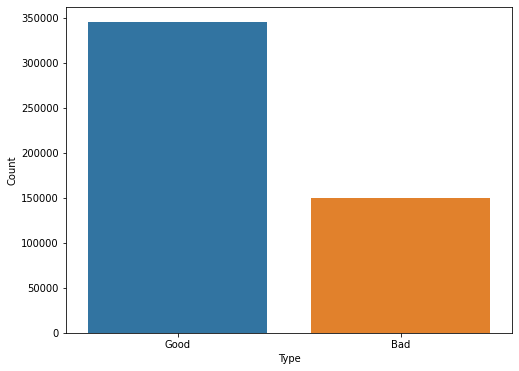

In [16]:
# Visualising our data
figure(figsize=(8, 6))
print(f"The number of good URLs in the dataset is: {url_df['label'].where(url_df['label'] == 'good').count()}")
print(f"The number of bad URLs in the dataset is: {url_df['label'].where(url_df['label'] == 'bad').count()}")
plot = sns.barplot(x = ['Good', 'Bad'], y = url_df['label'].value_counts())
plot.set(xlabel='Type', ylabel='Count')
plt.show();

We can see that the number of Good URLs is far more than Bad URLs in our dataset and that makes our data <b>imbalanced</b> we can try resampling to solve this particular issue.

In [17]:
good_urls = url_df[url_df['label'] == 'good']
bad_urls = url_df[url_df['label'] == 'bad']

In [18]:
good_urls.head(10)

,url,label
57994,01453.com/,good
57995,015fb31.netsolhost.com/bosstweed.html,good
57996,02bee66.netsolhost.com/lincolnhomepage/,good
57997,02ec0a3.netsolhost.com/getperson.php?personID=...,good
57998,032255.com/,good
57999,05minute.com/,good
58000,07090.blogspot.com/2011/07/westfield-police-of...,good
58001,08nrc.blogspot.com/,good
58002,0creditcard.biz/,good
58003,0dayreggaedancehall.blogspot.com/,good


In [19]:
bad_urls.head(10)

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
5,toddscarwash.com,bad
6,tubemoviez.com,bad
7,ipl.hk,bad
8,crackspider.us/toolbar/install.php?pack=exe,bad
9,pos-kupang.com/,bad


## Data Preprocessing
We have now succesfully merged our datasets and got one unified one, we can see that our independent feature is the name of the URL, that opens a lot of ways to deal with as an NLP task. 


In [20]:
url_df.sample(20)

,url,label
160635,sportingtimes.net/,good
238985,education.com/schoolfinder/us/ohio/west-union/...,good
141298,noizeline.com/,good
134200,montreal.theoffside.com/team-news/what-to-expe...,good
489467,walkonwheels.net.au/qmd1uu,bad
201617,archive.org/stream/alexandredumashi025763mbp/a...,good
290794,le-flamboyant.com/,good
323802,nfl-merchandise.blogspot.com/,good
99914,en.wikipedia.org/wiki/Sony_Ericsson,good
308032,mhpjnac.org/,good


#### Taking a quick look at the sample of our dataset we can see there are a lot of redundant things in our URL like '/ ',  ' : ',  ' . ', etc. these symbols are not neccessary for us. Further in the project we will be using TD-IDF Vectorizer to give scores to these URLs based on their lexical features. It will be a good if we will extract these words from the URL and remove all the redundant characters from it.


<ul>
<li>To do this operation we used Regexp Tokenizer. What it does is that it splits the string using a regular express that we pass and we get the list of words that we need for our analysis. </li>
    <li>According to the documentation: "A <b>RegexpTokenizer</b> splits a string into substrings using a regular expression."
    </ul>

In [21]:
tknizer = RegexpTokenizer(r'[A-Za-z]+')

In [22]:
tknizer.tokenize('http://localhost:8888/notebooks/Documents/Malicious%20URL%20Detection/URL%20Detection%20using%20Python.ipynb')

['http',
 'localhost',
 'notebooks',
 'Documents',
 'Malicious',
 'URL',
 'Detection',
 'URL',
 'Detection',
 'using',
 'Python',
 'ipynb']

Defining a small function to form a new column in our dataframe that contains the tokenized URLs 

In [122]:
def tokenizeUrl(url):
    return tknizer.tokenize(url)

start = process_time()
print('Starting the process to tokenize the URLs...')
# Creating a new column in our dataframe that keeps the tokenized form of the URLs
url_df['tokenized_url'] = url_df.url.map(tokenizeUrl)
end = process_time()
print(f'Process Finished! and took {end - start}s')

Starting the process to tokenize the URLs...
Process Finished! and took 2.078125


In [24]:
url_df.head(5)

,url,label,tokenized_url
0,diaryofagameaddict.com,bad,"[diaryofagameaddict, com]"
1,espdesign.com.au,bad,"[espdesign, com, au]"
2,iamagameaddict.com,bad,"[iamagameaddict, com]"
3,kalantzis.net,bad,"[kalantzis, net]"
4,slightlyoffcenter.net,bad,"[slightlyoffcenter, net]"


We only need the words of the URL not the commas that are seperating them in the list so we will define a function that removes the commas and append that as a new column 
in our Dataframe.

In [25]:
def clean_token(token):
    return ' '.join(token);

url_df['tokenized_url_cleaned'] = url_df['tokenized_url'].map(clean_token)

In [26]:
url_df.sample(10)

,url,label,tokenized_url,tokenized_url_cleaned
381689,webmii.com/Result.aspx?f=Kevin&l=O'Leary&r=intl,good,"[webmii, com, Result, aspx, f, Kevin, l, O, Le...",webmii com Result aspx f Kevin l O Leary r intl
302841,manta.com/c/mt1vd0y/louis-e-archambault-attorney,good,"[manta, com, c, mt, vd, y, louis, e, archambau...",manta com c mt vd y louis e archambault attorney
110234,freepages.genealogy.rootsweb.ancestry.com/~sna...,good,"[freepages, genealogy, rootsweb, ancestry, com...",freepages genealogy rootsweb ancestry com snay...
476135,ronnyrobreb.ru/sliva/gate.php,bad,"[ronnyrobreb, ru, sliva, gate, php]",ronnyrobreb ru sliva gate php
202142,archive.org/stream/stjohnbaptistder00unknuoft/...,good,"[archive, org, stream, stjohnbaptistder, unknu...",archive org stream stjohnbaptistder unknuoft s...
94446,en.wikipedia.org/wiki/Gray_Line_Worldwide,good,"[en, wikipedia, org, wiki, Gray, Line, Worldwide]",en wikipedia org wiki Gray Line Worldwide
307736,metrolyrics.com/more-than-a-woman-lyrics-bee-g...,good,"[metrolyrics, com, more, than, a, woman, lyric...",metrolyrics com more than a woman lyrics bee g...
311475,motorcycle.ohio.gov/,good,"[motorcycle, ohio, gov]",motorcycle ohio gov
253877,fanbase.com/Real-Salt-Lake-2006,good,"[fanbase, com, Real, Salt, Lake]",fanbase com Real Salt Lake
237025,e-laws.gov.on.ca/html/repealedstatutes/english...,good,"[e, laws, gov, on, ca, html, repealedstatutes,...",e laws gov on ca html repealedstatutes english...


## TF-IDF Vectorizer
We are using TF-IDF algorithm to transform our tokenized_urls into numerical representation that we further use in our Machine learning algorithm to make predictions. 

<br>

<b> What does TF-IDF vectorizer do? </b>


<br>
What it does is that it first calculates the term frequency i.e.
    
<br><b>Term Frequency</b>:  (Number of repetions of particular word in sentence)/(Number of words in sentence)

<br>
Then it calculates the Inverse document frequency i.e.

<br><b>IDF:</b> log((No. of sentences)/(No. of sentences containing that word))

<br> In the final step it multiplies TF and IDF and assigns that value to the word
    

In [123]:
vectorizer = TfidfVectorizer();

start = process_time()
print('Vectorizing URLs...')
url_names = vectorizer.fit_transform(url_df.tokenized_url_cleaned)
end = process_time()
print(f'Task Complete! and took {end - start}s')

Vectorizing URLs...
Task Complete! and took 3.859375s


In [64]:
print(url_names)

  (0, 48482)	0.10231646400215898
  (0, 61600)	0.9947518993166562
  (1, 16155)	0.3970381667481138
  (1, 75380)	0.9129853818363055
  (1, 48482)	0.0939062654912466
  (2, 109906)	0.9947518993166562
  (2, 48482)	0.10231646400215898
  (3, 165381)	0.29658225402341704
  (3, 125965)	0.9550073123271828
  (4, 218397)	0.9550073123271828
  (4, 165381)	0.29658225402341704
  (5, 238797)	0.9947518993166562
  (5, 48482)	0.10231646400215898
  (6, 242805)	0.9947518993166562
  (6, 48482)	0.10231646400215898
  (7, 105243)	0.5915670018960184
  (7, 115934)	0.8062558416952749
  (8, 77053)	0.23067532167102833
  (8, 178595)	0.38456164754167865
  (8, 184400)	0.14294829723710767
  (8, 114677)	0.37816326658622984
  (8, 239385)	0.4837278428336617
  (8, 247952)	0.23973868667278836
  (8, 52247)	0.5865085672978185
  (9, 132488)	0.8207845864082407
  :	:
  (494363, 48482)	0.057179754700464214
  (494366, 12112)	0.5588124872358071
  (494366, 42428)	0.7897982498440805
  (494366, 176397)	0.2528780904953177
  (494367, 12112)

In [77]:
# from imblearn.under_sampling import RandomUnderSampler


In [87]:
# rs = RandomUnderSampler()
# good_urls = url_df[url_df['label'] == 'good']
# bad_urls = url_df[url_df['label'] == 'bad']
# X_res, y_res = rs.fit_resample(url_df, url_df.label);

### Splitting the data for training and testing

In [ ]:
trainX, testX, trainY, testY = train_test_split(url_names, url_df.label)

## Logistic Regression
The first classification algorithm we used is <b>Logistic Regression</b>
<br>
We will be using two algorithms on this data and will deploy our model with the better performing one.

In [138]:
# An array to store the scores of both models
model_scores = []

In [125]:
logreg = LogisticRegression(max_iter=600)

In [126]:
print('********************************************************')
print('Applying Logistic Regression...')
start = process_time()
logreg.fit(trainX, trainY)
end = process_time()
print(f'Model is trained. It took {end - start} seconds to train the model!')
print('********************************************************')

******************************
Applying Logistic Regression...
Model is trained. It took 9.15625 seconds to train the model
******************************


In [140]:
print(f'The model has a {logreg.score(trainX, trainY) * 100:.2f}% Training accuracy')
print(f'The model has a {logreg.score(testX, testY) * 100:.2f}% Testing accuracy')
# Appending the logistic regression model score to our list
model_scores.append(logreg.score(testX, testY))

The model has a 97.81% Training accuracy
The model has a 96.93% Testing accuracy


### Confusion Matrix for Logistic Regression
Using the confusion matrix we can visualise that how accurate our model is

Classification Matrix for the model is: 



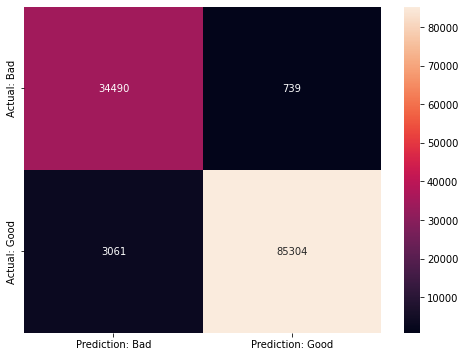

In [137]:
conf_mat = pd.DataFrame(confusion_matrix(logreg.predict(testX), testY), columns = ['Prediction: Bad', 'Prediction: Good'], index = ['Actual: Bad', 'Actual: Good'])
print('Classification Matrix for the model is: \n')
figure(figsize = (8, 6))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.show();

# Idhar karna aur isko delete kardena 

### We can see that Logistic Regression performs better than Random Forest Classfier on our dataset so we will dump our model as pickel file

In [141]:
pipeline_logreg = make_pipeline(TfidfVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize), LogisticRegression(max_iter=600))

In [142]:
trainX, testX, trainY, testY = train_test_split(url_df.url, url_df.label)

In [143]:
print('*******************************************')
print('Training...')
pipeline_logreg.fit(trainX,trainY)
print('Process Finished')
print('*******************************************')

*******************************************
Training...
Process Finished
*******************************************


In [144]:
print(f'The accuracy is: {pipeline_logreg.score(testX, testY)}')

The accuracy is: 0.9698529054808486


In [145]:
pickle.dump(pipeline_logreg,open('logreg.pkl','wb'))

In [146]:
loaded_logreg = pickle.load(open('logreg.pkl', 'rb'))
res = loaded_logreg.score(testX, testY)
print(res)

0.9698529054808486


In [147]:
url = ['stackoverflow.com/questions/']
res = loaded_logreg.predict(url)
print(res)

['good']
